In [1]:
# All imports
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm
from fastai.imports import *
from fastai.vision.all import *
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import SparseCategoricalCrossentropy
from tensorflow import keras
from PIL import Image
from numpy import asarray
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from scipy.io import loadmat 
import cv2
from tensorflow.keras import Sequential

In [2]:
# Retrieving files from our Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Unzipping files into colab
!unzip '/content/drive/My Drive/NNDL Project Submission/im.zip'

Streaming output truncated to the last 5000 lines.
  inflating: im/image_06851.jpg      
  inflating: __MACOSX/im/._image_06851.jpg  
  inflating: im/image_07597.jpg      
  inflating: __MACOSX/im/._image_07597.jpg  
  inflating: im/image_06689.jpg      
  inflating: __MACOSX/im/._image_06689.jpg  
  inflating: im/image_01680.jpg      
  inflating: __MACOSX/im/._image_01680.jpg  
  inflating: im/image_01858.jpg      
  inflating: __MACOSX/im/._image_01858.jpg  
  inflating: im/image_03097.jpg      
  inflating: __MACOSX/im/._image_03097.jpg  
  inflating: im/image_02389.jpg      
  inflating: __MACOSX/im/._image_02389.jpg  
  inflating: im/image_04920.jpg      
  inflating: __MACOSX/im/._image_04920.jpg  
  inflating: im/image_03083.jpg      
  inflating: __MACOSX/im/._image_03083.jpg  
  inflating: im/image_04934.jpg      
  inflating: __MACOSX/im/._image_04934.jpg  
  inflating: im/image_01694.jpg      
  inflating: __MACOSX/im/._image_01694.jpg  
  inflating: im/image_06845.jpg     

In [4]:
# Input for the labels of our images
labels = '/content/drive/My Drive/NNDL Project/imagelabels.mat'
image_labels = loadmat(labels)
image_labels.keys()

dict_keys(['__header__', '__version__', '__globals__', 'labels'])

In [5]:
# Adding our image_labels into a dataframe to match with our images
df = pd.DataFrame()
labels = image_labels['labels'].transpose()
labels = labels -1
df = pd.DataFrame(labels, columns = ['image_label'])

In [6]:
# Adding our image paths to our image_labels dataframe
image_path = []
for i in range (1,len(labels)+1):
  if i<10:
    x = '0000' + str(i)
  elif i<100:
    x = '000' + str(i)
  elif i<1000:
    x = '00' + str(i)
  elif i<10000:
    x = '0' + str(i)
  else:
    break
  image_path.append('/content/im/image_'+x+'.jpg')

df["image_path"] = image_path 

In [7]:
# Checking how many images we have per class (top few and bottom few to understand the distributioin of samples)
df.image_label.value_counts()

50    258
76    251
45    196
72    194
88    184
     ... 
6      40
44     40
33     40
0      40
26     40
Name: image_label, Length: 102, dtype: int64

In [8]:
# Test to see whether the path code works to open the 1st image
im = Image.open(df['image_path'][0])
width, height = im.size
print(width,height)

591 500


In [9]:
# Final check on our data frame before loading the images and converting them to (size, size, 3) numpy pixels
df

,image_label,image_path
0,76,/content/im/image_00001.jpg
1,76,/content/im/image_00002.jpg
2,76,/content/im/image_00003.jpg
3,76,/content/im/image_00004.jpg
4,76,/content/im/image_00005.jpg
...,...,...
8184,61,/content/im/image_08185.jpg
8185,61,/content/im/image_08186.jpg
8186,61,/content/im/image_08187.jpg
8187,61,/content/im/image_08188.jpg


In [10]:
# Function to load images, convert to numpy array of pixel data, split into train test split, convert to a tensor and return. (Based on img_size input)
def split_function(train_df,img_size):
    data = train_df.copy()
    img_size = img_size
    train_image = []
    for i in tqdm(range(data.shape[0])):
      # inputting images with the required input size
      img = image.load_img(data['image_path'][i],target_size=(img_size,img_size,3))
      img = image.img_to_array(img)
      train_image.append(img)
    # appending the image arrays to a new numpy array
    train_df = np.array(train_image)
    image_label = data['image_label'].to_numpy()
    # train, val, test split (0.7, 0.2, 0.1)
    X_train, X_test, y_train, y_test = train_test_split(train_df, image_label, random_state=42, test_size=0.3, stratify = image_label)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=42, test_size=0.33, stratify = y_test)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    print('Number of training samples ', len(train_ds))
    print('Number of validation samples ', len(val_ds))
    print('Number of test samples ', len(test_ds))

    # Batching and applying prefetching for faster processing
    train_ds = train_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    val_ds = val_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    test_ds = test_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    print('Number of training samples after batching ', len(train_ds))
    print('Number of validation samples after batching ', len(val_ds))
    print('Number of test samples after batching ', len(test_ds))

    # Returning the y_val and y_test as well since it is needed for our ensemble learning model
    
    return(train_ds, val_ds, test_ds, y_val, y_test)

In [11]:
train_ds, val_ds, test_ds, y_val, y_test = split_function(df, 224)

100%|██████████| 8189/8189 [00:41<00:00, 198.76it/s]


Number of training samples  5732
Number of validation samples  1646
Number of test samples  811
Number of training samples after batching  180
Number of validation samples after batching  52
Number of test samples after batching  26


In [12]:
# Retrieving the names of the top 5 models that we have fine tuned and saved the weights
top_5_finetuned_models = []

pre_trained = pd.read_csv('/content/drive/My Drive/NNDL Project Submission/transfer_learning_model_results_pure.csv')
for i in tqdm(range(5)):
  top_5_finetuned_models.append(pre_trained['pretrained_model_name'][i])

100%|██████████| 5/5 [00:00<00:00, 11066.77it/s]


In [13]:
top_5_finetuned_models

['EfficientNetV2B2',
 'EfficientNetB2',
 'EfficientNetB1',
 'EfficientNetV2B1',
 'DenseNet201']

In [14]:
# Making each of our 5 models predict on the test data and output probabilities of the image belonging to the 102 classes

# We get the probabilistic output of the classifier and we build our ensemble model on this prediction
y_pred = []
models = []

for model in top_5_finetuned_models:
  fine_tuned_model = keras.models.load_model('/content/drive/My Drive/NNDL Project Submission/trained_finetuned_models/'+model)
  models.append(fine_tuned_model)
  y_pred.append(fine_tuned_model.predict(test_ds))

26/26 [==============================] - 11s 210ms/step


In [15]:
# Function to ensemble the outputs from each of the 5 models by adding up the probabilities they output per test sample. Ensemble models tend to perform better since they work together to give a final output
# Since each of our models predicts a certain probability it is very unlikely that two probabilistic outputs from the model of a test sample belonging to a particular class will be the same
# Therefore we use each of the models learning ability to work together and make a final prediction on the class the test sample belongs to

# Summation ensemble predictions
def sum_ensemble_prediction(y_pred, y_test):
  # Summing up the probabilistic outputs per test sample
  sums = np.sum(y_pred, axis = 0)
  # Selecting the class which has the highest probability per test sample
  results = np.argmax(sums, axis=1)
  # Calculating the accuracy of our predictions
  return (sum(results==y_test)/len(results))

In [16]:
print('Sum Ensemble Predictions Accuracy : ', sum_ensemble_prediction(y_pred, y_test))

Sum Ensemble Predictions Accuracy :  0.9765721331689272


As we can see the accuracy of our predictions has been bumped up with the use of an ensemble model. Our individual models were giving an average accuracy of 96% and while working together they now give an accuracy of **97.65%**

Now we shall try a more advanced ensembling method where we use a new neural network to make a prediction based on the outputs of the 5 best pretrained models. The new network takes in the outputs of the best pretrained models as an input and then makes a final prediction based on this

In [17]:
y_val_pred = []
for model in models:
  y_val_pred.append(model.predict(val_ds))

52/52 [==============================] - 9s 181ms/step


In [18]:
y_val_pred_train = []

for i in tqdm(range(1646)):
  temp = []
  for j in range(5):
    temp.append(list(y_val_pred[j][i]))
  y_val_pred_train.append(temp)

y_val_pred_train = np.array(y_val_pred_train)

ensemble_train_ds = tf.data.Dataset.from_tensor_slices((y_val_pred_train, y_val))

ensemble_train_ds = ensemble_train_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

100%|██████████| 1646/1646 [00:00<00:00, 22162.80it/s]


In [19]:
def ensemble_model():
  model = Sequential()
  model.add(tf.keras.Input(shape=(5,102,)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(102, activation='softmax'))
  return model

In [20]:
y_pred_test = []

for i in tqdm(range(811)):
  temp = []
  for j in range(5):
    temp.append(list(y_pred[j][i]))
  y_pred_test.append(temp)

y_pred_test = np.array(y_pred_test)



100%|██████████| 811/811 [00:00<00:00, 21722.43it/s]


In [33]:
ensemble_test_ds = tf.data.Dataset.from_tensor_slices((y_pred_test, y_test))
ensemble_test_ds = ensemble_test_ds.cache().batch(32).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [34]:
# Early stopping implementation to reduce over fitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# training our ensemble model
model = ensemble_model()
model.compile(optimizer=keras.optimizers.Adam(),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

history = model.fit(ensemble_train_ds, epochs = 50, validation_data = ensemble_test_ds)

Epoch 1/50
52/52 [==============================] - 1s 6ms/step - loss: 4.2426 - accuracy: 0.1762 - val_loss: 3.2941 - val_accuracy: 0.3946
Epoch 2/50
52/52 [==============================] - 0s 4ms/step - loss: 2.4033 - accuracy: 0.5547 - val_loss: 1.1933 - val_accuracy: 0.8693
Epoch 3/50
52/52 [==============================] - 0s 4ms/step - loss: 0.8336 - accuracy: 0.8773 - val_loss: 0.2853 - val_accuracy: 0.9766
Epoch 4/50
52/52 [==============================] - 0s 4ms/step - loss: 0.2982 - accuracy: 0.9708 - val_loss: 0.1546 - val_accuracy: 0.9741
Epoch 5/50
52/52 [==============================] - 0s 4ms/step - loss: 0.1570 - accuracy: 0.9824 - val_loss: 0.1384 - val_accuracy: 0.9766
Epoch 6/50
52/52 [==============================] - 0s 4ms/step - loss: 0.1153 - accuracy: 0.9842 - val_loss: 0.1426 - val_accuracy: 0.9753
Epoch 7/50
52/52 [==============================] - 0s 4ms/step - loss: 0.0744 - accuracy: 0.9903 - val_loss: 0.1376 - val_accuracy: 0.9778
Epoch 8/50
52/52 [==

Text(0, 0.5, 'Accuracy')

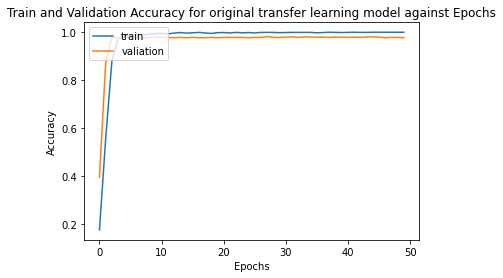

In [36]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('Train and Validation Accuracy for original transfer learning model against Epochs')
plt.legend(['train', 'valiation'], loc = 'upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [37]:
y_test_pred = model.predict(y_pred_test)

labels = []

for i in range(len(y_test_pred)):
  labels.append(np.argmax(y_test_pred[i]))

26/26 [==============================] - 0s 1ms/step


In [38]:
print('Accuracy : ', sum(labels==y_test)/len(y_test))

Accuracy :  0.9753390875462392
